In [8]:
# Initially I collate some libraries required for the DICOM validation check.

import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color

In [9]:
# In the next step we read the .dcm file and validate if all requirements of Pneumonia-Checker are fulfilled.
# Inspired by https://github.com/glungu/udacity-healthcare-ai/blob/master/02-medical-imaging-2d/project-chest-xray-pneumonia-detection/Inference.ipynb

def check_dicom(filename, verbose=False): 
    if verbose:
        print(f'Loading file: {filename} ...')
    
    dcm = pydicom.dcmread(filename)       
    
    # Body Part: only Chest X-Rays can be analyzed for Pneumonia as aspired.
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Body part {body_part}, for Pneumonia-Check needs to be Chest')
        return None
    
    # Patient Position: needs to be PA or AP
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position {pos}, for Pneumonia-Check needs to be AP or PA')
        return None
    
    # Modality: needs to be DX
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'Image {filename} rejected, Modality {mod}, for Pneumonia-Check needs to be DX')
        return None
 
    # Age requirement: between 18 and 72 years of age, but not hard criteria
    age = int(dcm.PatientAge)
    if age < 18 or age > 72:
        print(f'Image {filename} ATTENTION! Patient Age {age} outside Pneumonia_Check required age range between 18 and 72')
        return dcm.pixel_array
    
    return dcm.pixel_array

In [10]:
# Following this step we reshape the image to fit to our model's requirements.
def preprocess_image(img, img_mean, img_std, img_size, verbose=False): 
    
    if verbose:
        print(f'Image data: {img.shape}')
    
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
        
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)

    if verbose:
        print(f'Resized data: {resized_img.shape}')

    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)

    if verbose:
        print(f'Processed data: {proc_img.shape}')

    return proc_img

In [11]:
# In the next step we load in the Pneumonia-Checker model.

def load_model(model_path, weight_path):
    
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)

    # load weights into new model
    model.load_weights(weight_path)
    
    return model

In [12]:
# In this step a check is conducted if Pneumonia-Checker identifies Pneumonia on the image.

def predict_image(model, img, threshold): 
    
    pred = model.predict(img)
    prediction = pred > threshold
    
    return prediction[0][0]

Image test1.dcm ATTENTION! Patient Age 81 outside Pneumonia_Check required age range between 18 and 72
Image test3.dcm ATTENTION! Patient Age 77 outside Pneumonia_Check required age range between 18 and 72
Image test4.dcm rejected, Body part RIBCAGE, for Pneumonia-Check needs to be Chest
Image test5.dcm rejected, Modality CT for Pneumonia-Check needs to be DX
Image test6.dcm rejected, Patient position XX, for Pneumonia-Check needs to be AP or PA


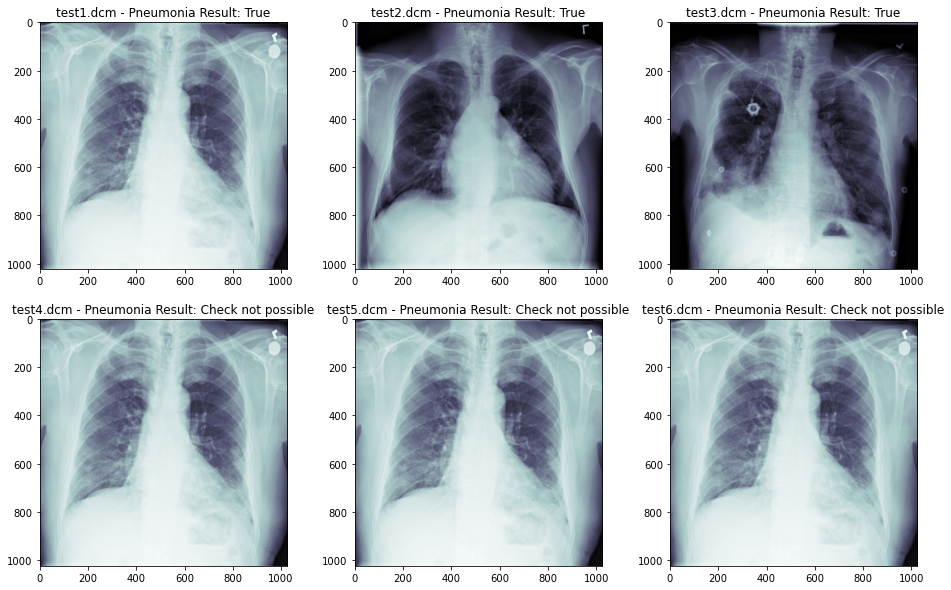

In [13]:
# Now we can run the validation of the Test images and Check for Pneumonia 
# or respectively if Pneumonia-Checker can operate on these files.

test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']
model_path = 'Pneumonia_Checker_1.json'
weight_path = 'xray_class_Pneumonia_Checker_1.best.hdf5'

# VGG16 / Pneumonia-Checker requirement for image scaling.
IMG_SIZE=(1,224,224,3)

# Rescale function used in preprocessing normalizes the image data automatically.
img_mean = -1           
img_std = -1

Pneumonia_Checker = load_model(model_path, weight_path) 
threshold = 0.31                                   

def predict_dicom(filename):
    
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return 'Check not possible'
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(Pneumonia_Checker,img_proc,threshold)
    return pred

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)
    
for i,filename in enumerate(test_dicoms):
    pred = predict_dicom(filename)
    img = pydicom.dcmread(filename).pixel_array        
    
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename} - Pneumonia Result: {pred}')
    
    plt.imshow(img, cmap='bone')

plt.show()